In [53]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [54]:
original = cv2.imread('mouse.jpg', 0)

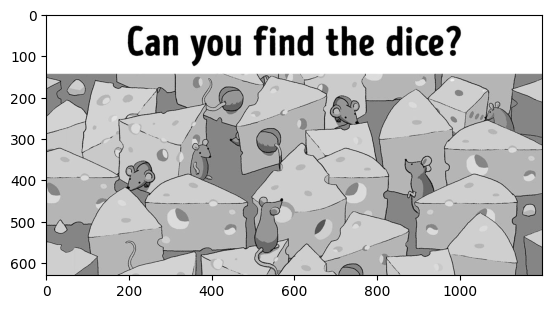

In [55]:
plt.imshow(original, cmap='gray')

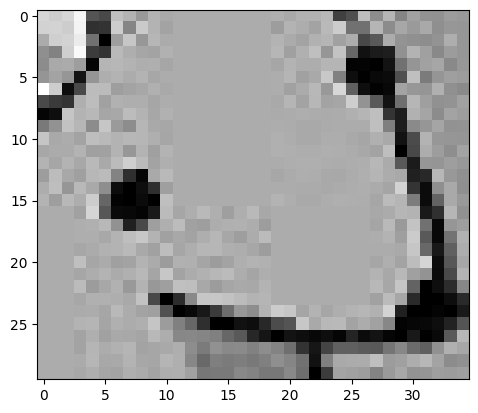

In [56]:
mouse = original[320:350, 365:400]
plt.imshow(mouse, cmap='gray')

array([[187, 183, 180, ..., 135, 135, 134],
       [186, 183, 181, ..., 134, 134, 133],
       [183, 183, 183, ..., 132, 132, 131],
       ...,
       [150, 150, 150, ..., 125, 126, 128],
       [150, 150, 150, ..., 132, 133, 135],
       [150, 150, 150, ..., 136, 137, 139]], dtype=uint8)
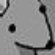

In [57]:
template= cv2.resize(mouse, (55, 55))
template

In [58]:
def edge_detection(image):
    blur = cv2.GaussianBlur(image, (5,5), 0)
    edges = cv2.Canny(blur, 0, 50)
    return edges

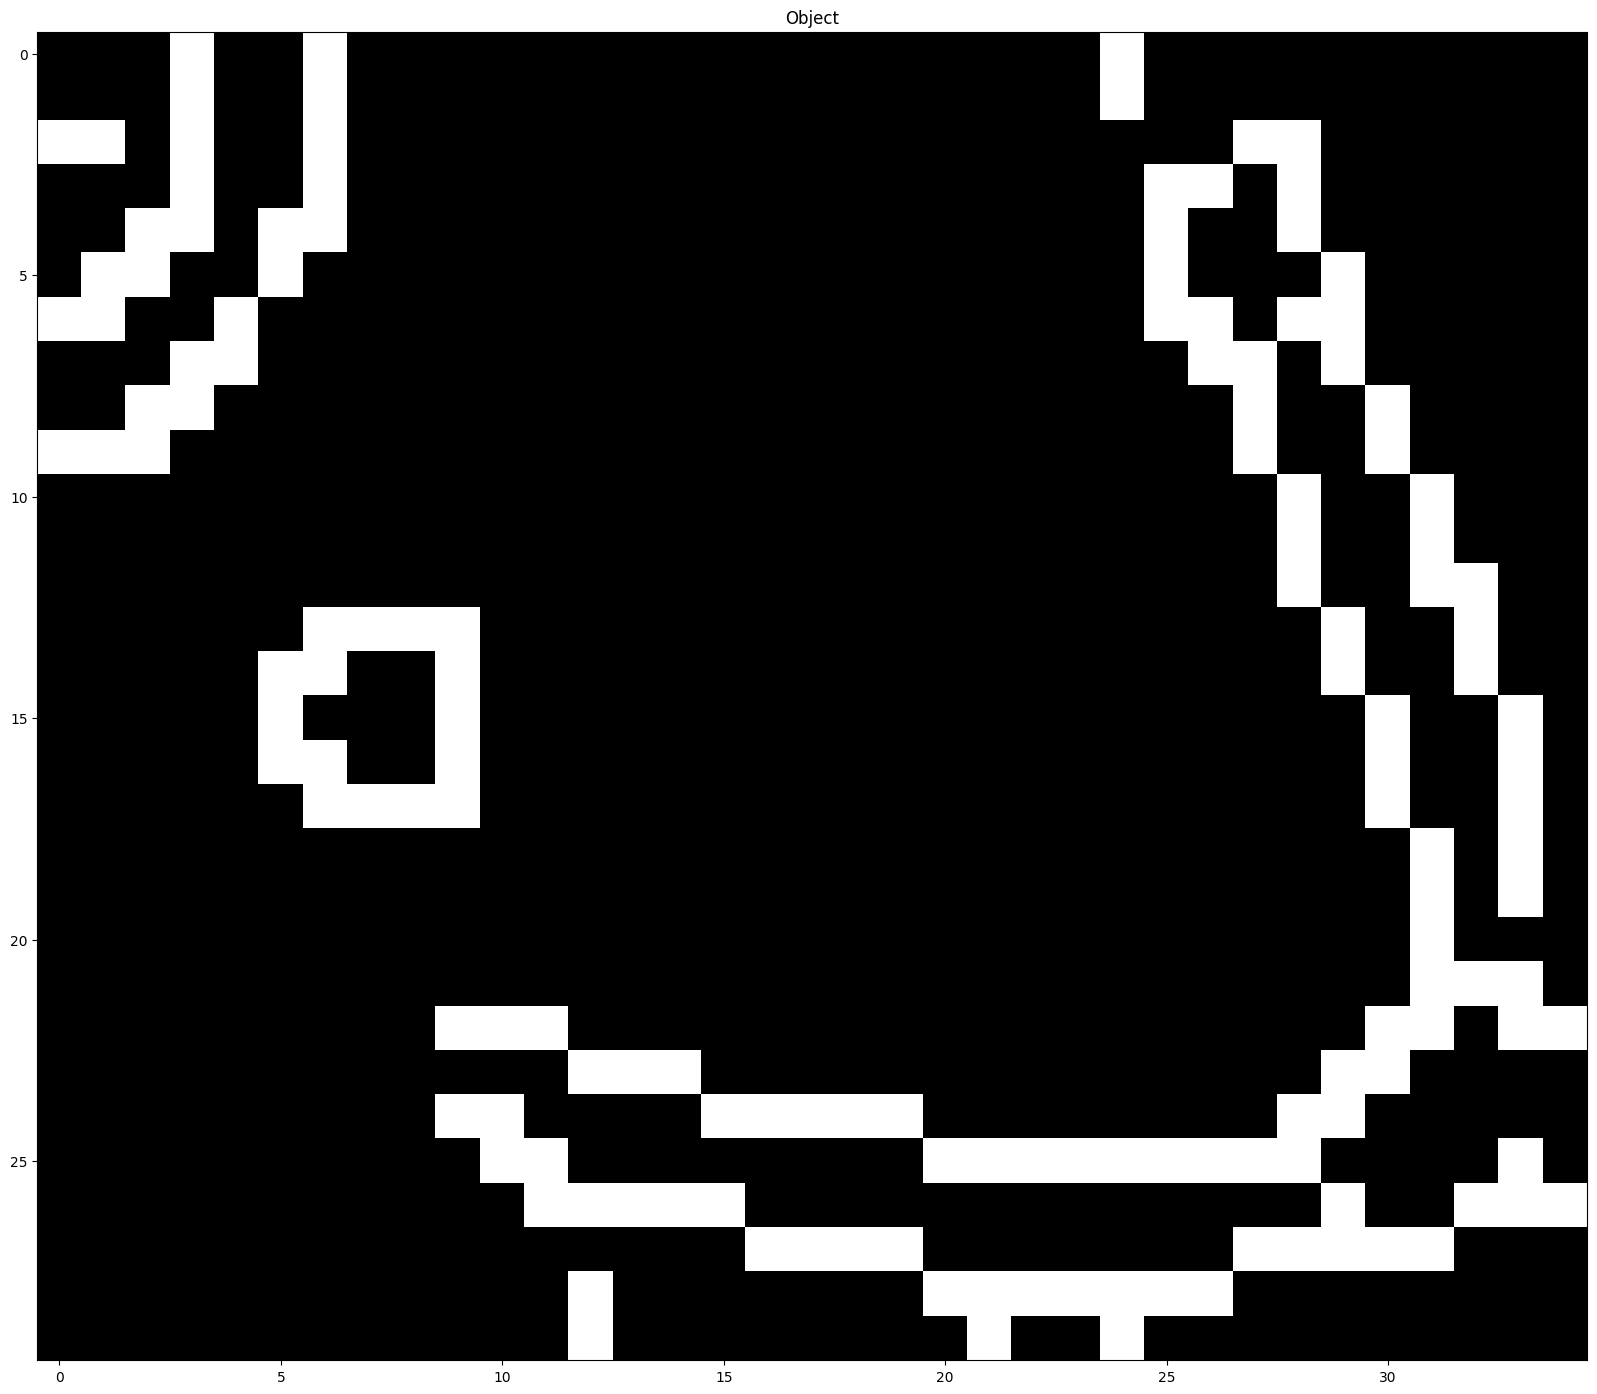

In [59]:

edge = edge_detection(mouse)
plt.figure(figsize=(20, 20))
plt.imshow(edge, cmap='gray')
plt.title('Object')
plt.show()


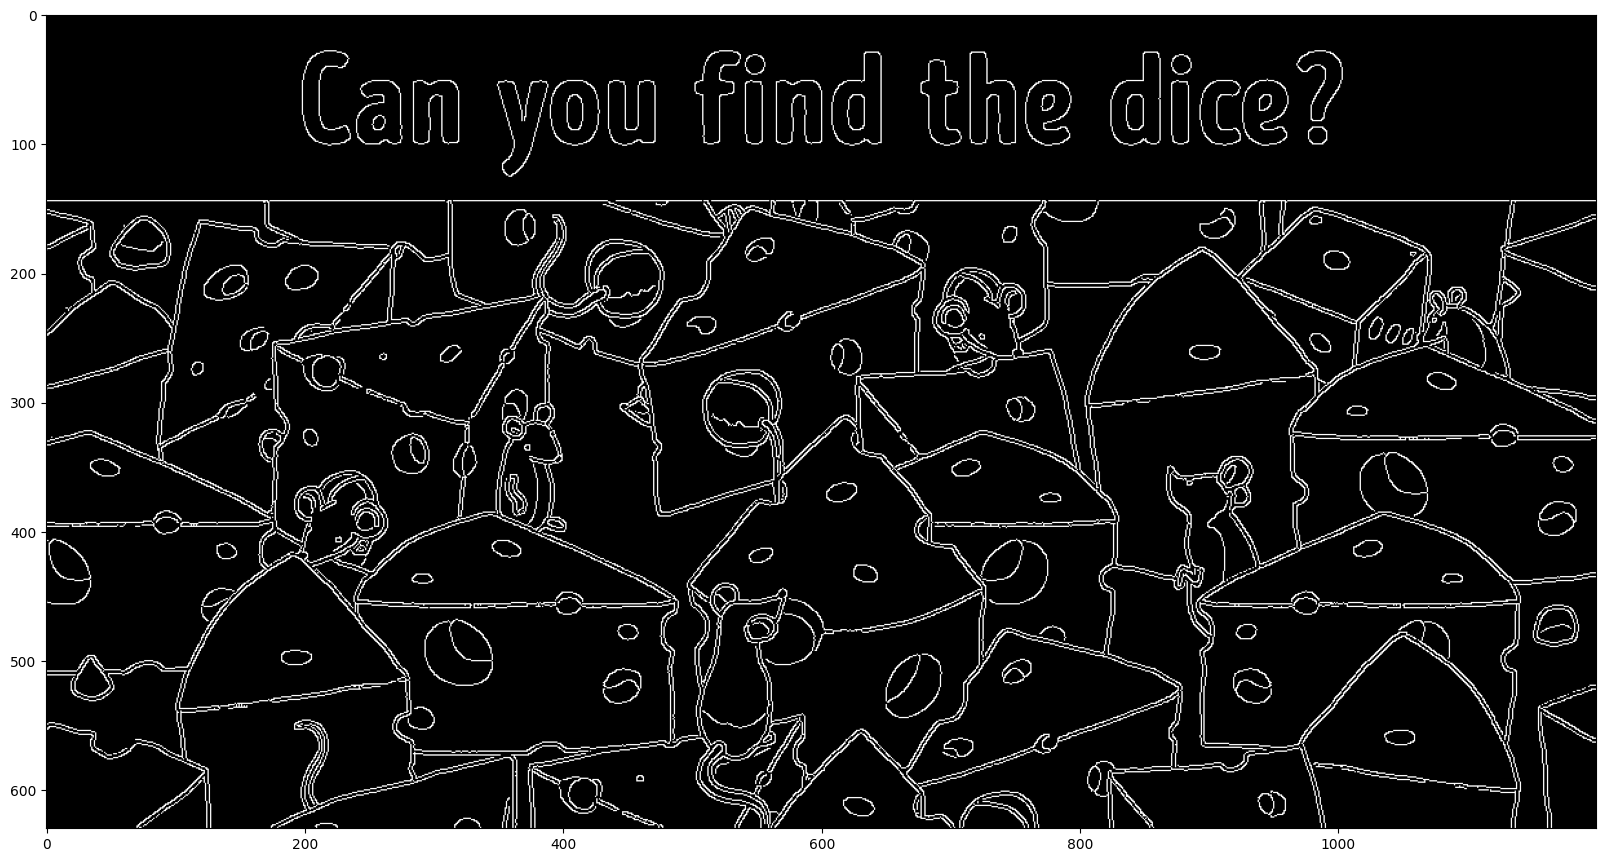

In [60]:
target_edges = edge_detection(original)
plt.figure(figsize=(20, 20))
plt.imshow(target_edges, cmap='gray', )

In [61]:
import cv2
import numpy as np

# Hàm để xoay mẫu (template) theo các góc khác nhau
def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Tạo ma trận xoay
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h))

    return rotated

# Hàm để lật mẫu (template)
def flip_image(image, flip_code):
    return cv2.flip(image, flip_code)

# Hàm non-maximum suppression để loại bỏ các vùng chồng lấn
def non_max_suppression(detections, overlapThresh):
    if len(detections) == 0:
        return []

    # Chuyển tọa độ từ (x, y, w, h) sang (x1, y1, x2, y2)
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in detections])

    pick = []

    x1 = rects[:, 0]
    y1 = rects[:, 1]
    x2 = rects[:, 2]
    y2 = rects[:, 3]
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)

    while len(idxs) > 0:
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Tìm tọa độ giao nhau
        xx1 = np.maximum(x1[i], x1[idxs[:-1]])
        yy1 = np.maximum(y1[i], y1[idxs[:-1]])
        xx2 = np.minimum(x2[i], x2[idxs[:-1]])
        yy2 = np.minimum(y2[i], y2[idxs[:-1]])

        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:-1]]

        # Loại bỏ các hình chữ nhật có mức độ chồng lấn lớn hơn ngưỡng
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    return rects[pick].astype(int)

# Các góc xoay sẽ áp dụng cho mẫu
rotation_angles = [-45, 45, 90]  # Xoay trái 45 độ, xoay phải 45 độ, và xoay 90 độ
flip_codes = [0, 1]  # 0: lật dọc, 1: lật ngang

# Để thực hiện template matching với các mẫu đã xoay và lật
threshold = 0.45
scale_factors = np.linspace(0.8, 1.4, 100).tolist()
detections = []

for scale in scale_factors:
    # Thay đổi kích thước của mẫu
    scaled_template = cv2.resize(edge, None, fx=scale, fy=scale)

    # Thực hiện khớp mẫu với kích thước thay đổi
    res = cv2.matchTemplate(target_edges, scaled_template, cv2.TM_CCOEFF_NORMED)
    loc = np.where(res >= threshold)
    for pt in zip(*loc[::-1]):
        detections.append((pt[0], pt[1], scaled_template.shape[1], scaled_template.shape[0]))

    # Thực hiện khớp mẫu với các mẫu đã xoay
    for angle in rotation_angles:
        rotated_template = rotate_image(scaled_template, angle)
        res = cv2.matchTemplate(target_edges, rotated_template, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            detections.append((pt[0], pt[1], rotated_template.shape[1], rotated_template.shape[0]))

    # Thực hiện khớp mẫu với các mẫu đã lật
    for flip_code in flip_codes:
        flipped_template = flip_image(scaled_template, flip_code)
        res = cv2.matchTemplate(target_edges, flipped_template, cv2.TM_CCOEFF_NORMED)
        loc = np.where(res >= threshold)
        for pt in zip(*loc[::-1]):
            detections.append((pt[0], pt[1], flipped_template.shape[1], flipped_template.shape[0]))

# Non-maximum suppression để loại bỏ vùng chồng lấn
final_detections = non_max_suppression(detections, overlapThresh=0.1)

# Vẽ các hình chữ nhật cho các vùng phát hiện cuối cùng
for (x1, y1, x2, y2) in final_detections:
    cv2.rectangle(target_edges, (x1, y1), (x2, y2), (255, 0, 0), 2)

print(f"Number of matches: {len(final_detections)}")

# Lưu ảnh với các kết quả phát hiện
cv2.imwrite('detected_matches.jpg', target_edges)


Number of matches: 9


True

In [62]:
for (x1, y1, x2, y2) in final_detections:
    cv2.rectangle(original, (x1, y1), (x2, y2), (0, 0, 0), 2)

In [63]:
cv2.rectangle(original, (x1, y1), (x2, y2), (0, 0, 0), 2)

array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [207, 207, 207, ..., 133, 133, 133],
       [207, 207, 207, ..., 133, 133, 133],
       [207, 207, 207, ..., 133, 133, 133]], dtype=uint8)